In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
#!pip install classification-models-3D
#!pip install efficientnet-3D
!pip install segmentation-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 67.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninsta

In [4]:
!pip install patchify

In [5]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [34]:
print(np.__version__)

1.23.5


In [6]:
# Import libraries
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
#import segmentation_models_3D as sm
from patchify import patchify, unpatchify
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [100]:
train_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/window/tro_w6.npy')
train_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_train_mask.npy')
validation_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/window/vo_w6.npy')
validation_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_validation_mask.npy')
#test_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/window/testo_w1.npy')
#test_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_test_mask.npy')

In [101]:
print("Shape of the data:", train_original_3D.shape)
print("Shape of the data:", test_mask_3D.shape)

Shape of the data: (112, 128, 128, 64, 3)
Shape of the data: (16, 128, 128, 64, 2)


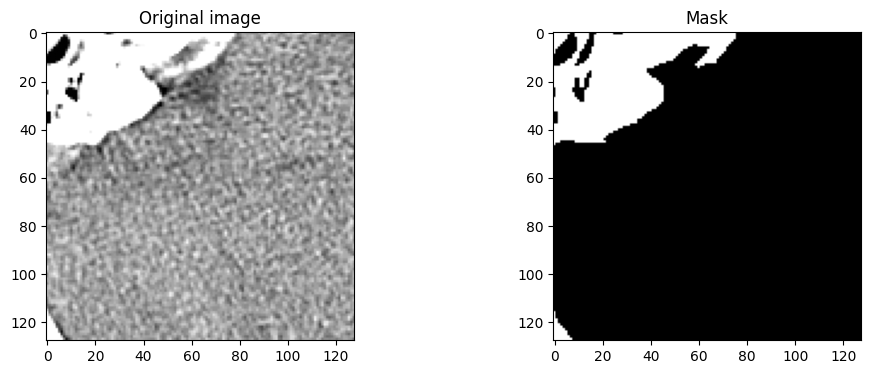

In [103]:
# Check the patches
# Change the patch and slice
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_3D[105,:,:,33,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_3D[105,:,:,33,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [104]:
# Normalization of the data
scaler = MinMaxScaler()
#train_original_3D = scaler.fit_transform(train_original_with_gaussian_noise.reshape(-1, train_original_with_gaussian_noise.shape[-1])).reshape(train_original_with_gaussian_noise.shape)
train_original_3D = scaler.fit_transform(train_original_3D.reshape(-1, train_original_3D.shape[-1])).reshape(train_original_3D.shape)
validation_original_3D = scaler.fit_transform(validation_original_3D.reshape(-1, validation_original_3D.shape[-1])).reshape(validation_original_3D.shape)
test_original_3D = scaler.fit_transform(test_original_3D.reshape(-1, test_original_3D.shape[-1])).reshape(test_original_3D.shape)

In [105]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [106]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [107]:
metrics = [sm.metrics.IOUScore(threshold=0.5)]

In [38]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, Activation

In [108]:
kernel_initializer =  'he_uniform'

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #model.summary()

    return model

In [109]:
model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=64,
                          IMG_CHANNELS=1,
                          num_classes=1)

In [110]:
model.compile(optimizer = optim, loss=dice_loss, metrics=metrics)
#print(model.summary())

In [ ]:
from tensorflow.keras.callbacks import Callback

In [ ]:
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image[:,:,43], cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask[:,:,43], cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask[:,:,43], cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [ ]:
save_dir = '/content/drive/MyDrive/3DPart/3D/Model_training_prediction/originalunet3d_window'
os.makedirs(save_dir, exist_ok=True)

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_3D[:,:,:,:,0], validation_mask_3D[:,:,:,:,0]), save_dir=save_dir)

In [111]:
history = model.fit(train_original_3D[:,:,:,:,0],
          train_mask_3D[:,:,:,:,0],
          batch_size = 4,
          epochs = 100,
          verbose = 1,
          validation_data=(validation_original_3D[:,:,:,:,0], validation_mask_3D[:,:,:,:,0]))
          #callbacks=[save_predictions_callback])

Epoch 1/100
28/28 [==============================] - 16s 193ms/step - loss: 0.7884 - iou_score: 0.1184 - val_loss: 0.7586 - val_iou_score: 0.1904
Epoch 2/100
28/28 [==============================] - 5s 161ms/step - loss: 0.7469 - iou_score: 0.2221 - val_loss: 0.7483 - val_iou_score: 0.2089
Epoch 3/100
28/28 [==============================] - 5s 162ms/step - loss: 0.7298 - iou_score: 0.2717 - val_loss: 0.7358 - val_iou_score: 0.2131
Epoch 4/100
28/28 [==============================] - 5s 163ms/step - loss: 0.7105 - iou_score: 0.3297 - val_loss: 0.7146 - val_iou_score: 0.2243
Epoch 5/100
28/28 [==============================] - 4s 161ms/step - loss: 0.7019 - iou_score: 0.4306 - val_loss: 0.6893 - val_iou_score: 0.3965
Epoch 6/100
28/28 [==============================] - 5s 161ms/step - loss: 0.6979 - iou_score: 0.4830 - val_loss: 0.6824 - val_iou_score: 0.5899
Epoch 7/100
28/28 [==============================] - 5s 161ms/step - loss: 0.6908 - iou_score: 0.5196 - val_loss: 0.6706 - val_io

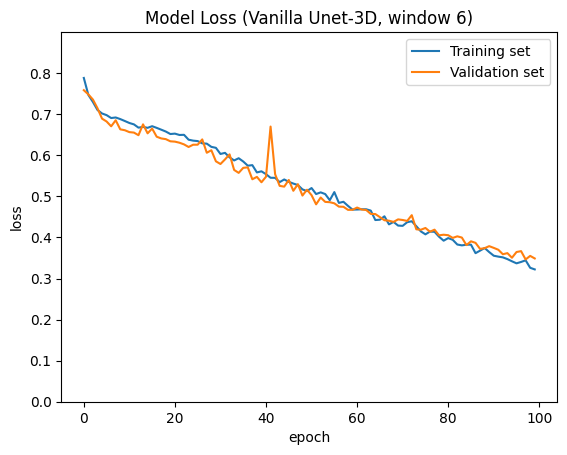

In [112]:
# Plot loss function
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 0.9)
plt.yticks(np.arange(0, 0.9, 0.1))
plt.title('Model Loss (Vanilla Unet-3D, window 6)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

In [113]:
model.save('/content/drive/MyDrive/3DPart/3D/3DUNetModel/vanilla_unet3d_window6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
